# Prediction skill of temperature and specific humidity tendencies

### Importing packages and data_utils.py

In [1]:
from climsim_utils.data_utils import *

2023-08-21 16:25:37.644365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 16:25:53.040170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Instantiating class

In [2]:
grid_path = '/ocean/projects/atm200007p/jlin96/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/ClimSim/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

scoring_data = data_utils(grid_info = grid_info, 
                          input_mean = input_mean, 
                          input_max = input_max, 
                          input_min = input_min, 
                          output_scale = output_scale)

### Loading data and setting pressure grid

In [4]:
# paths to scoring data
input_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'
target_scoring_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'

# paths to model predictions
cnn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_predict_cnn_reshaped_stride6_FINAL.npy'
ed_pred_path = '/ocean/projects/atm200007p/behrens/ED_Behrens_2022/ED_ClimSIM_1_3_pred.npy'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
mlp_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'
rpn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/rpn_pred_v1_stride6.npy'
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'

# set path to original data
scoring_data.data_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train/'

# path to target input
scoring_data.input_scoring = np.load(input_scoring_path)

# path to target output
scoring_data.target_scoring = np.load(target_scoring_path)

# set pressure weights
scoring_data.set_pressure_grid(data_split = 'scoring')

# set regular expressions for selecting data
scoring_data.set_regexps(data_split = 'scoring', regexps = ['E3SM-MMF.mli.0008-0[23456789]-*-*.nc', 
                                                            'E3SM-MMF.mli.0008-1[012]-*-*.nc', 
                                                            'E3SM-MMF.mli.0009-01-*-*.nc'])
# set temporal subsampling
scoring_data.set_stride_sample(data_split = 'scoring', stride_sample = 6)

# create list of files to extract data from
scoring_data.set_filelist(data_split = 'scoring')

# create pressure grid
pressure_grid_plotting = scoring_data.get_pressure_grid_plotting(data_split = 'scoring')

# load target output
scoring_data.target_scoring = np.load(target_scoring_path)

# make a separate copy
scoring_data_copy = copy.deepcopy(scoring_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [03:04<00:00, 23.72it/s]


In [6]:
# load model predictions part 1
scoring_data.model_names = ['CNN','ED', 'HSR']
preds = [scoring_data.load_npy_file(load_path = cnn_pred_path),
         scoring_data.load_npy_file(load_path = ed_pred_path), 
         scoring_data.load_h5_file(load_path = hsr_pred_path)]
scoring_data.preds_scoring = dict(zip(scoring_data.model_names, preds))

# load model predictions part 2
scoring_data_copy.model_names = ['MLP', 'RPN', 'cVAE']
preds_copy = [scoring_data_copy.load_npy_file(load_path = mlp_pred_path), 
              scoring_data_copy.load_npy_file(load_path = rpn_pred_path),
              scoring_data_copy.load_h5_file(load_path = cvae_pred_path)]
scoring_data_copy.preds_scoring = dict(zip(scoring_data_copy.model_names, preds_copy))

### Plot pressure latitude R2 analysis

In [7]:
%config InlineBackend.figure_format = 'retina'

/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:792: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[0,i].pcolor(X, Y, coeff,cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:799: RuntimeWarning: divide by zero encountered in divide
  coeff = 1 - np.sum( (pred_moist_daily_long-test_moist_daily_long)**2, axis=1)/np.sum( (test_moist_daily_long-np.mean(test_moist_daily_long, axis=1)[:,None,:])**2, axis=1)
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:803: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

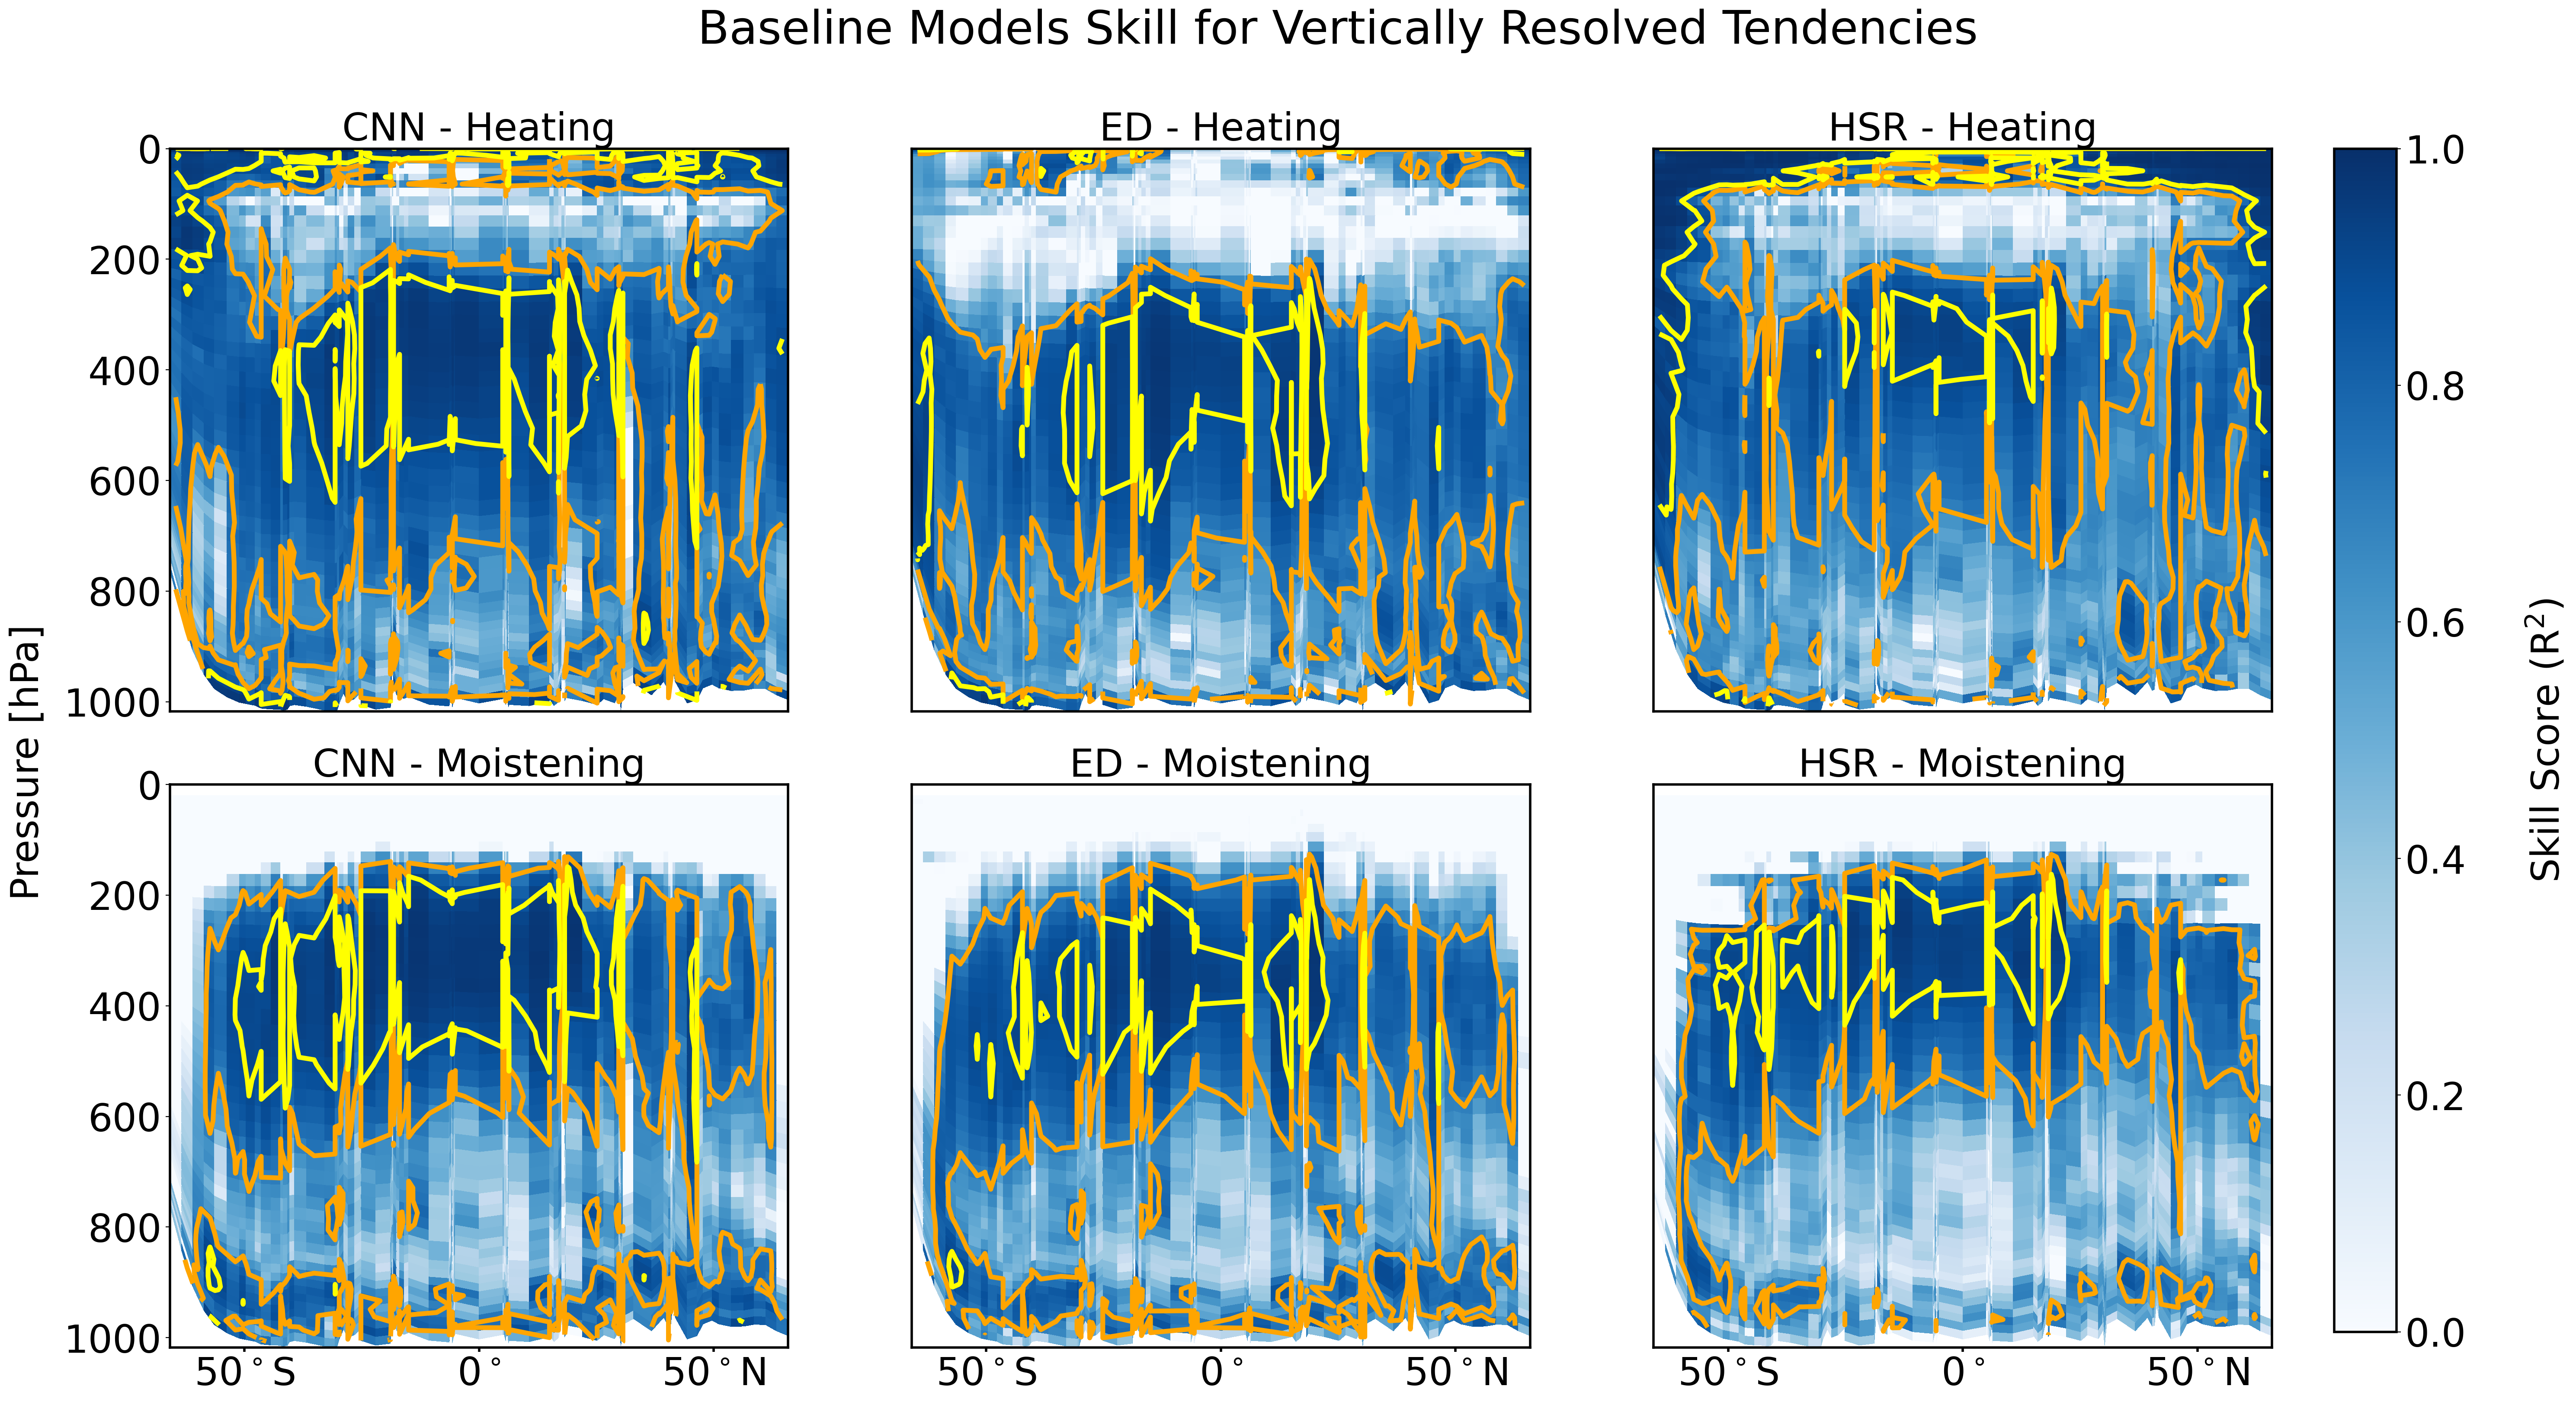

<Figure size 640x480 with 0 Axes>

In [8]:
scoring_data.plot_r2_analysis(pressure_grid_plotting = pressure_grid_plotting)

/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:792: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  contour_plot = ax[0,i].pcolor(X, Y, coeff,cmap='Blues', vmin = 0, vmax = 1) # pcolormesh
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:799: RuntimeWarning: divide by zero encountered in divide
  coeff = 1 - np.sum( (pred_moist_daily_long-test_moist_daily_long)**2, axis=1)/np.sum( (test_moist_daily_long-np.mean(test_moist_daily_long, axis=1)[:,None,:])**2, axis=1)
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:803: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell ed

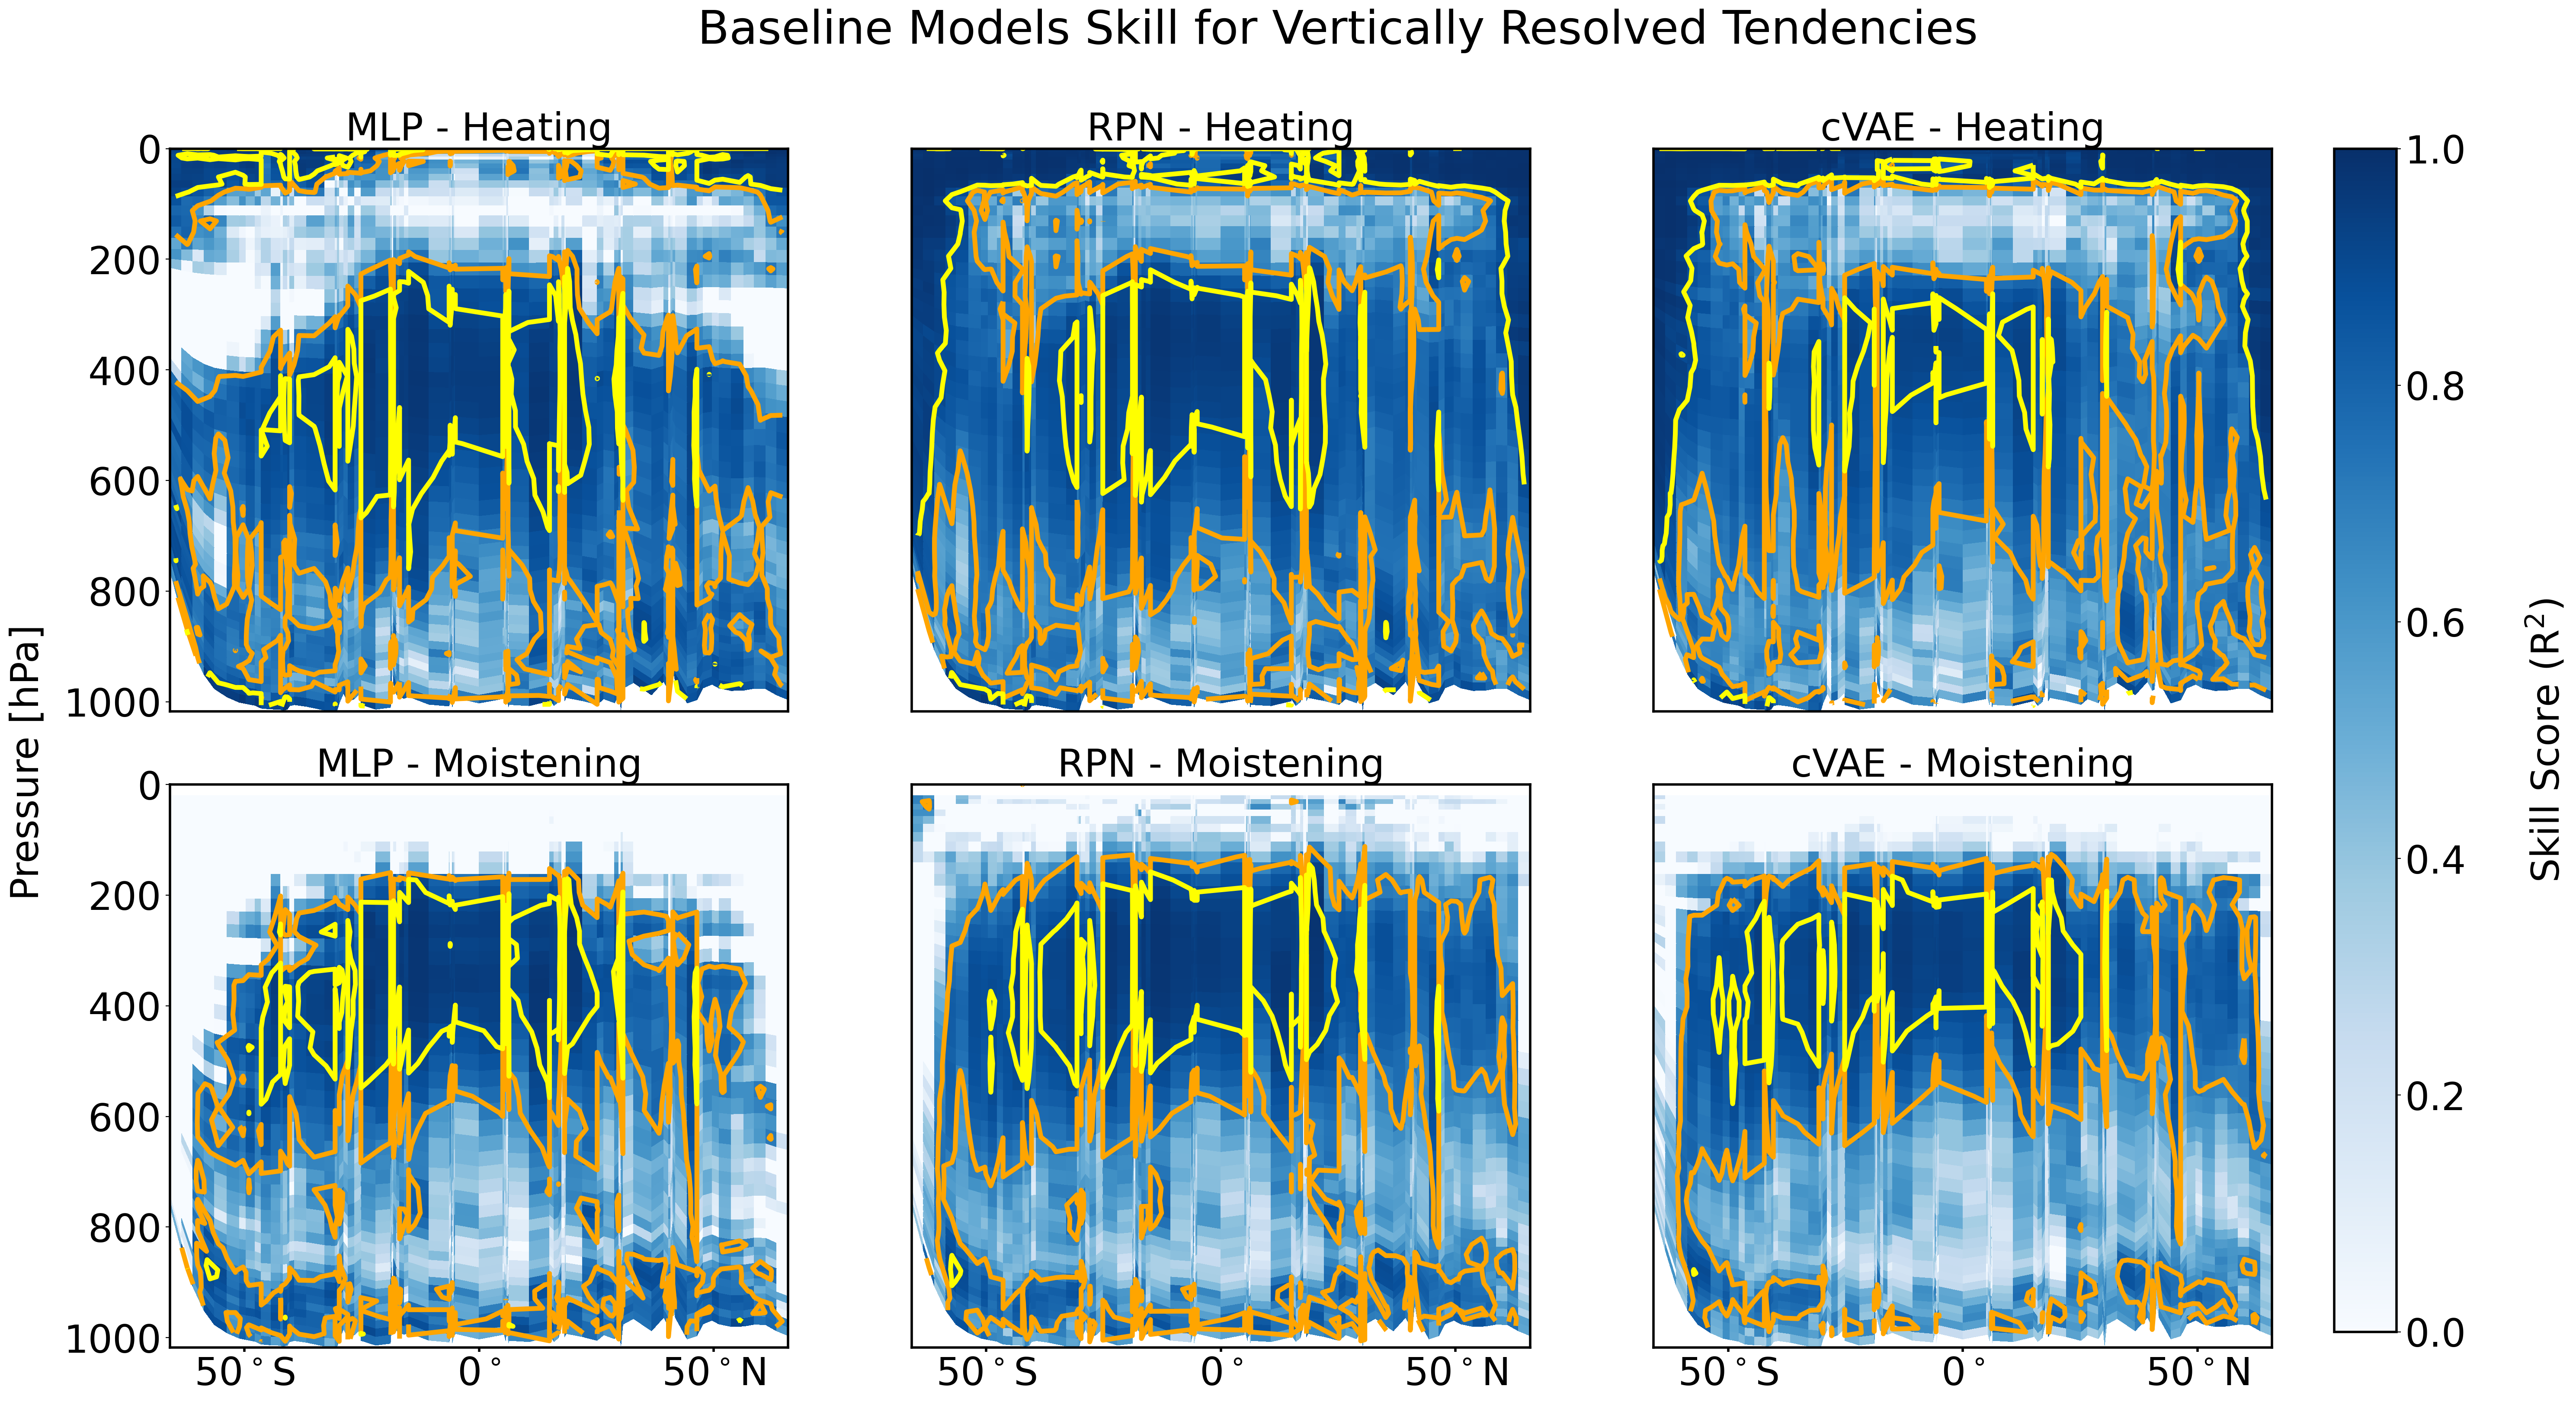

In [9]:
scoring_data_copy.plot_r2_analysis(pressure_grid_plotting = pressure_grid_plotting)